In [1]:
#1. Import packages
import datetime
import pickle, os

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import category_encoders as ce
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#2.Data Loading
PATH = os.getcwd()
csv_path = os.path.join(PATH,'train.csv')
df = pd.read_csv(csv_path)

In [3]:
#3. Data Inspection
print("Shape of the date =", df.shape)
print("\nInfo about the dataframe =\n", df.info())
print("\nDesc of the dataframe =\n", df.describe().transpose())
print("\nExample data =\n", df.head(1))

Shape of the date = (31647, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                31647 non-null  object 
 1   customer_age                      31028 non-null  float64
 2   job_type                          31647 non-null  object 
 3   marital                           31497 non-null  object 
 4   education                         31647 non-null  object 
 5   default                           31647 non-null  object 
 6   balance                           31248 non-null  float64
 7   housing_loan                      31647 non-null  object 
 8   personal_loan                     31498 non-null  object 
 9   communication_type                31647 non-null  object 
 10  day_of_month                      31647 non-null  int64  
 11  month                             3

In [4]:
#4. Data Cleaning (EDA)
print(df.isna().sum())
print(df.duplicated().sum())

id                                      0
customer_age                          619
job_type                                0
marital                               150
education                               0
default                                 0
balance                               399
housing_loan                            0
personal_loan                         149
communication_type                      0
day_of_month                            0
month                                   0
last_contact_duration                 311
num_contacts_in_campaign              112
days_since_prev_campaign_contact    25831
num_contacts_prev_campaign              0
prev_campaign_outcome                   0
term_deposit_subscribed                 0
dtype: int64
0


In [5]:
#check number of categories in each column
df.nunique()

id                                  31647
customer_age                           77
job_type                               12
marital                                 3
education                               4
default                                 2
balance                              6563
housing_loan                            2
personal_loan                           2
communication_type                      3
day_of_month                           31
month                                  12
last_contact_duration                1447
num_contacts_in_campaign               46
days_since_prev_campaign_contact      511
num_contacts_prev_campaign             41
prev_campaign_outcome                   4
term_deposit_subscribed                 2
dtype: int64

In [6]:
df.columns  #get the keys of each col

Index(['id', 'customer_age', 'job_type', 'marital', 'education', 'default',
       'balance', 'housing_loan', 'personal_loan', 'communication_type',
       'day_of_month', 'month', 'last_contact_duration',
       'num_contacts_in_campaign', 'days_since_prev_campaign_contact',
       'num_contacts_prev_campaign', 'prev_campaign_outcome',
       'term_deposit_subscribed'],
      dtype='object')

In [7]:
#continuous data
df_con = df[['customer_age', 'balance','day_of_month','last_contact_duration',
       'num_contacts_in_campaign', 'days_since_prev_campaign_contact',
       'num_contacts_prev_campaign']]
#categorical data
df_cat = df.drop(df_con.columns, axis=1)
df_cat.drop("id", axis=1, inplace=True)

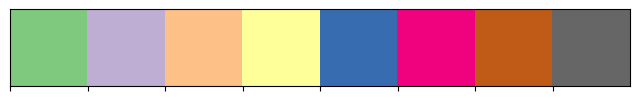

In [8]:
# 4.1 Setting Color Palette for data visualization

sns.palplot(sns.color_palette("Accent"))
sns.set_palette("Accent")
sns.set_style('whitegrid')

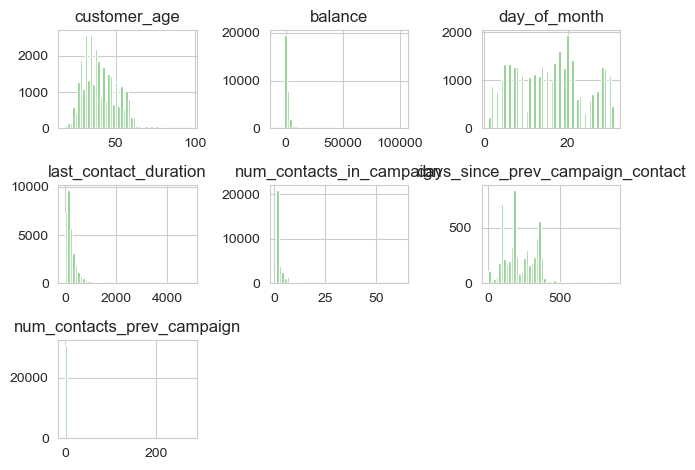

In [9]:
# 4.2 Histograms for all Continuous Variables

df_con.hist(bins=50, layout=(3,3))
plt.tight_layout()

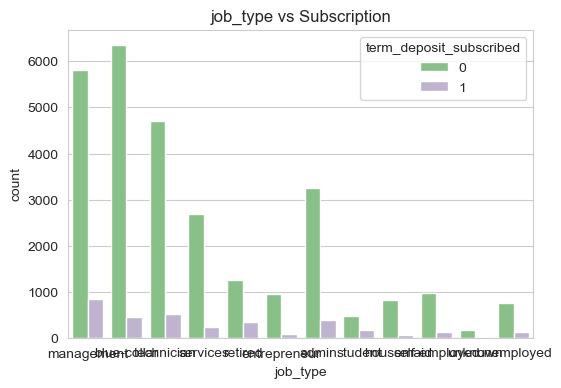

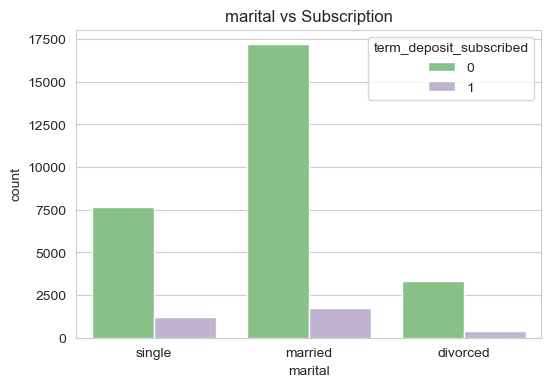

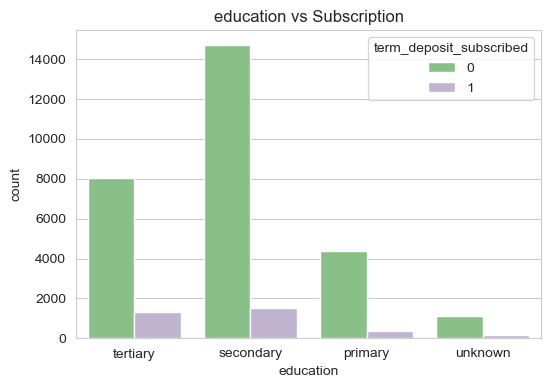

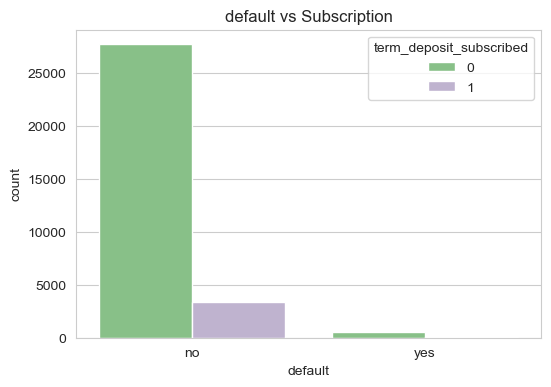

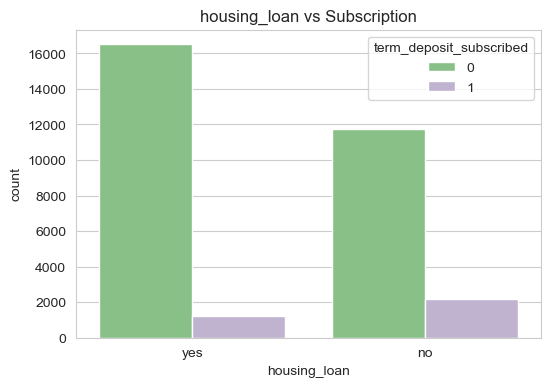

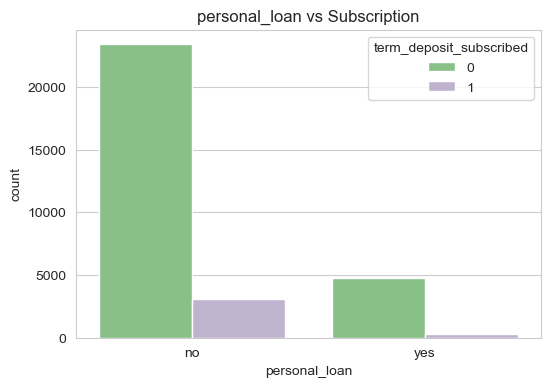

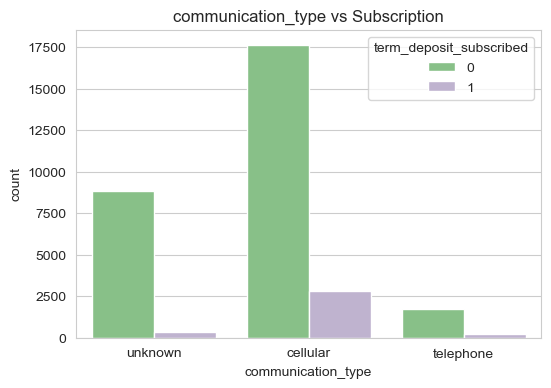

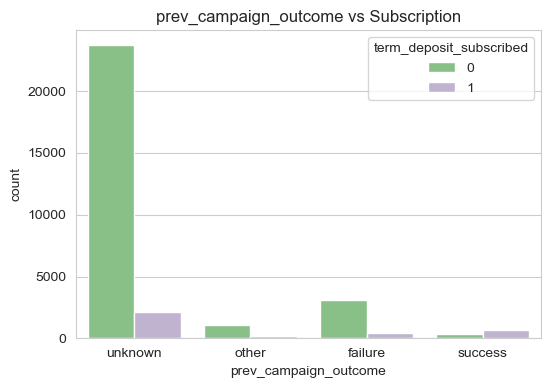

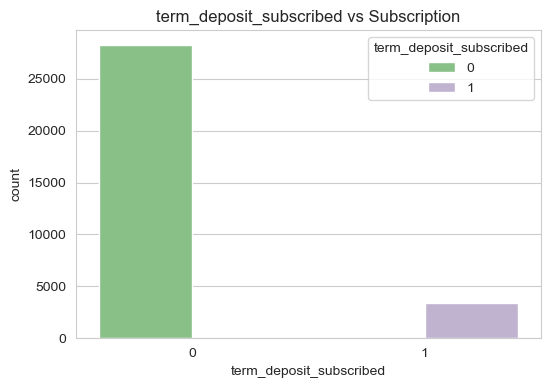

In [10]:
# 4.3 Countplot Vs term_deposit_subscribed for all Categorical Variables
df_cat.drop("month", axis=1, inplace=True)
for column in df_cat.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x=column, data=df_cat, hue='term_deposit_subscribed')

    plt.title(f'{column} vs Subscription')

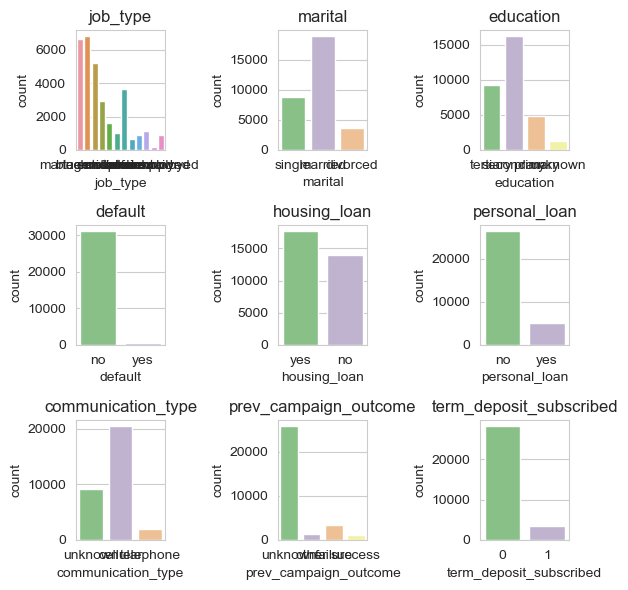

In [11]:
# 4.4 countplot for all cat cols
fig, axs = plt.subplots(3,3, figsize=(6,6))

axs = axs.ravel()

for i, column in enumerate(df_cat.columns):
    sns.countplot(x=column, data=df_cat, ax=axs[i])

    axs[i].set_title(f'{column}')

plt.tight_layout()

<Axes: >

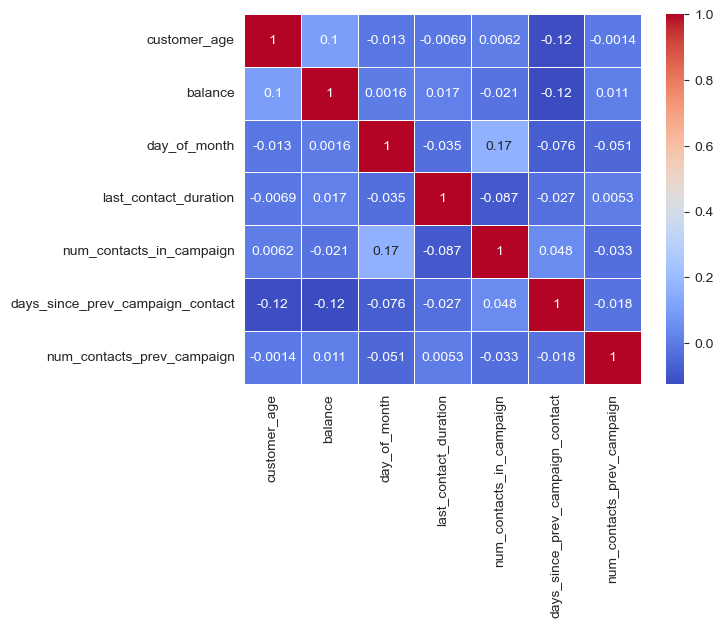

In [12]:
# 4.5 Correlation Matrix
sns.heatmap(df_con.corr(), annot=True, cmap='coolwarm', linewidths=0.5)

In [13]:
#5. Data Cleaning
# 5.1 Dealing with missing values
#filter out missing values
df[df.isnull().any(axis=1)]

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0
5,id_12681,65.0,retired,married,primary,no,2880.0,no,no,cellular,23,apr,163.0,1.0,NaN,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31639,id_3872,40.0,entrepreneur,married,tertiary,no,2.0,yes,yes,cellular,2,feb,852.0,4.0,NaN,0,unknown,0
31643,id_20428,51.0,management,married,tertiary,no,1072.0,no,no,unknown,20,jun,31.0,7.0,NaN,0,unknown,0
31644,id_44679,41.0,unemployed,married,primary,no,242.0,yes,no,unknown,23,may,89.0,2.0,NaN,0,unknown,0
31645,id_4841,48.0,services,married,secondary,no,2699.0,no,no,cellular,11,aug,216.0,6.0,NaN,0,unknown,0


In [14]:
# (a) customer_age
#try 5 different ways of impute the missing values, and plot histogram & violin plots to see the differences#Create deep copies of the original dataframe fo each of the imputation methods
df_drop = df.dropna(subset=['customer_age']).copy()
df_zero = df.copy()
df_mode = df.copy()
df_mean = df.copy()
df_median = df.copy()

#Apply different imputation to each
df_zero['customer_age'].fillna(0, inplace=True)
df_mode['customer_age'].fillna(df['customer_age'].mode()[0], inplace=True)
df_mean['customer_age'].fillna(df['customer_age'].mean(), inplace=True)
df_median['customer_age'].fillna(df['customer_age'].median(), inplace=True)

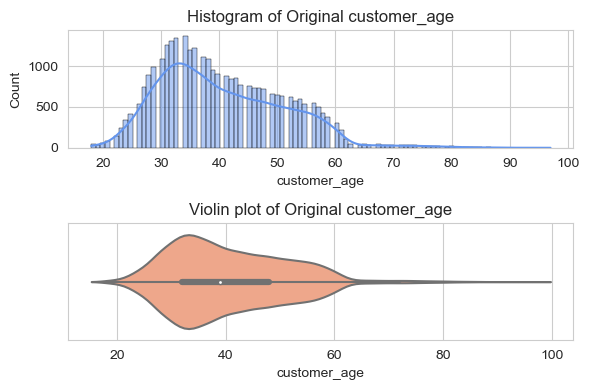

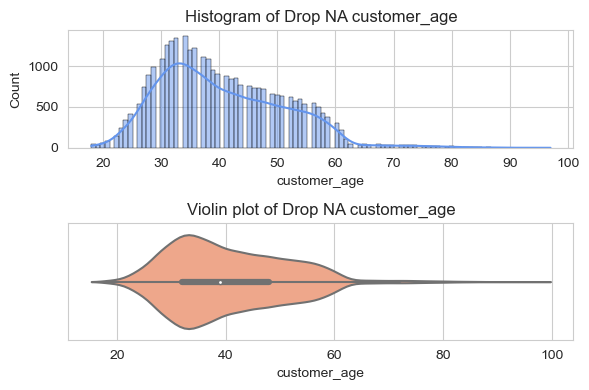

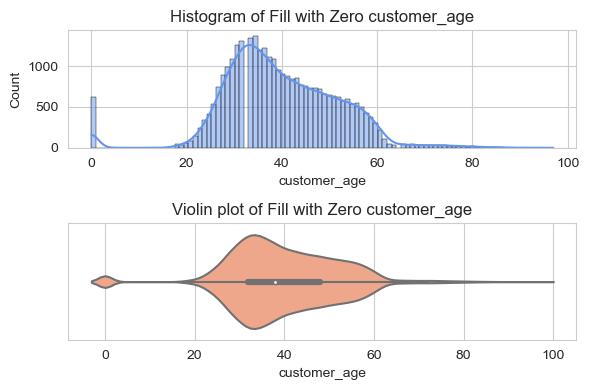

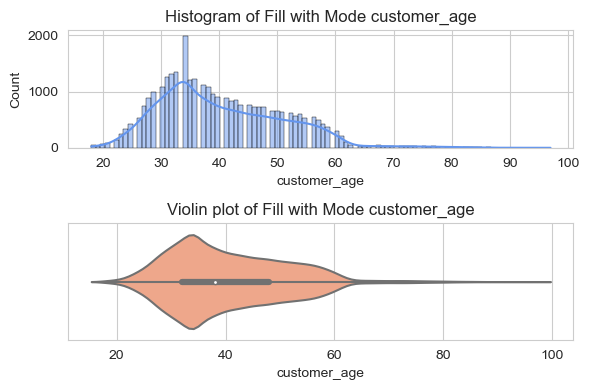

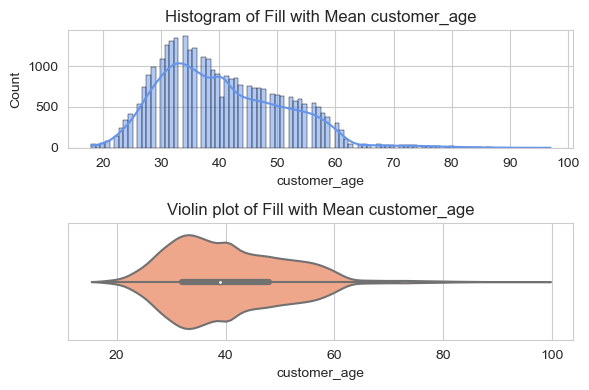

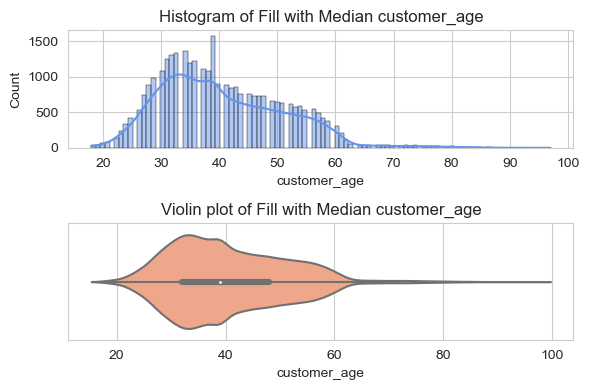

In [15]:
#plot histograms and violins plots for each of the imputation methods
dfs = [df, df_drop, df_zero, df_mode, df_mean, df_median]
titles = ['Original', 'Drop NA', 'Fill with Zero', 'Fill with Mode', 'Fill with Mean', 'Fill with Median']
for i, (df_temp, title) in enumerate(zip(dfs, titles)):
    plt.figure(figsize=(6, 4))
    #hist
    plt.subplot(2,1,1)
    sns.histplot(df_temp['customer_age'], bins=100, color='cornflowerblue', edgecolor='k', kde=True)
    plt.title(f'Histogram of {title} customer_age')

    #violin
    plt.subplot(2,1,2)
    sns.violinplot(x = df_temp['customer_age'], color='lightsalmon')
    plt.title(f'Violin plot of {title} customer_age')
    plt.tight_layout()
    plt.show()

In [16]:
#print all the stats of Age col of the imputed dataframes
for df_temp, title in zip(dfs, titles):

    print(f'Descriptive statistics for {title} Age:')
    print(df_temp['customer_age'].describe())

Descriptive statistics for Original Age:
count    31028.000000
mean        40.439216
std         10.751392
min         18.000000
25%         32.000000
50%         39.000000
75%         48.000000
max         97.000000
Name: customer_age, dtype: float64
Descriptive statistics for Drop NA Age:
count    31028.000000
mean        40.439216
std         10.751392
min         18.000000
25%         32.000000
50%         39.000000
75%         48.000000
max         97.000000
Name: customer_age, dtype: float64
Descriptive statistics for Fill with Zero Age:
count    31647.000000
mean        39.648245
std         12.028842
min          0.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         97.000000
Name: customer_age, dtype: float64
Descriptive statistics for Fill with Mode Age:
count    31647.000000
mean        40.313268
std         10.683005
min         18.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         97.000000
Name: customer_a

In [17]:
#for the customer_age above, filling the null value with mean is ideal however there is also marital status that needs to be considered to be more precise and realistic
# (b) fill null value for marital with unknown as we can't assume whether their status
df["marital"] = df["marital"].fillna("unknown")
print(df['marital'].nunique())

4


            count       mean        std   min   25%   50%    75%   max
marital                                                               
divorced   3622.0  45.442021  10.377297  23.0  37.0  45.0  53.00  97.0
married   18580.0  42.840312  10.372837  19.0  35.0  42.0  50.00  93.0
single     8680.0  33.212788   7.797619  18.0  28.0  32.0  37.00  87.0
unknown     146.0  40.390411  11.376548  23.0  32.0  38.0  47.75  80.0


<Figure size 1000x600 with 0 Axes>

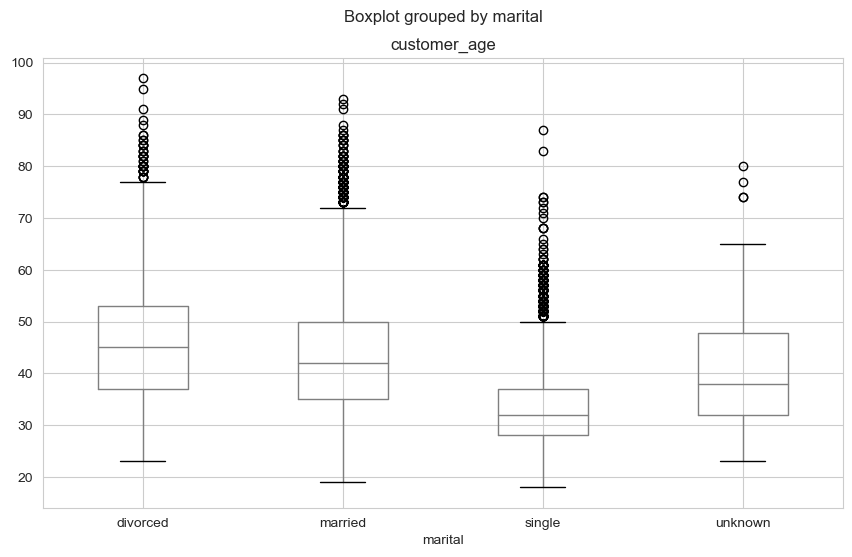

In [18]:
#check the substantial differences to decide whether it is relevant or not to consider the marital status

# Group the data by marital status
age_by_marital = df.groupby('marital')['customer_age']

# Calculate summary statistics within each group
age_summary = age_by_marital.describe()

# Create a boxplot to visualize the age distribution within each marital status
plt.figure(figsize=(10, 6))
df.boxplot(column='customer_age', by='marital', figsize=(10, 6))


# Print the summary statistics
print(age_summary)

In [19]:
#since there are substantial differences bewteen customer_age and marital status, to fill the null age by based on their marital status can be considered
# Create a copy of the original DataFrame to store imputed ages
df_age = df.copy()

# Calculate the mean ages for each marital status category
mar = df_age[df_age["marital"] == "married"]["customer_age"].mean()
unm = df_age[df_age["marital"] == "single"]["customer_age"].mean()
unk = df_age[df_age["marital"] == "unknown"]["customer_age"].mean()

print(mar, unm, unk )

# Loop through the DataFrame to impute missing ages
for i in range(len(df_age)):
    if np.isnan(df_age["customer_age"][i]):
        if df_age["marital"][i] == "single":
            df_age.at[i, "customer_age"] = round(unm)
        if df_age["marital"][i] == "married":
            df_age.at[i, "customer_age"] = round(mar)
        if df_age["marital"][i] == "divorced":
            df_age.at[i, "customer_age"] = round(mar)
        if df_age["marital"][i] == "unknown":
            df_age.at[i, "customer_age"] = round(unk)

42.840312163616794 33.21278801843318 40.39041095890411


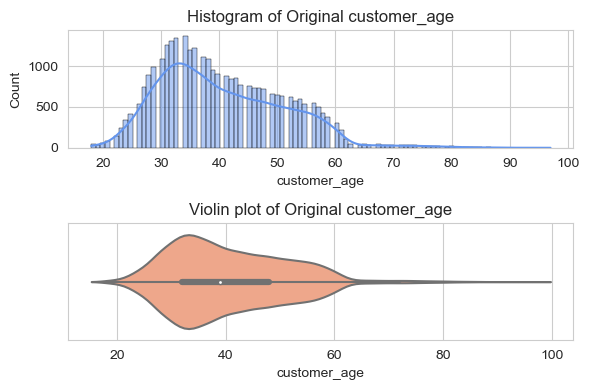

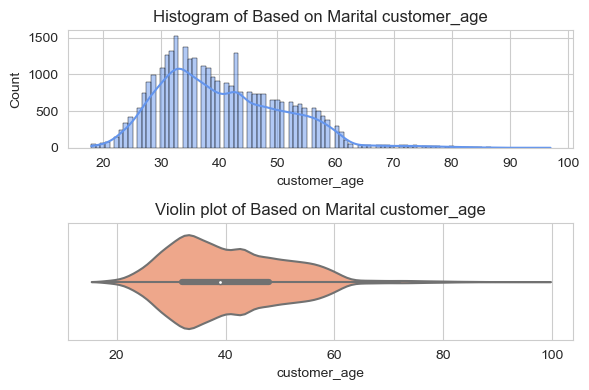

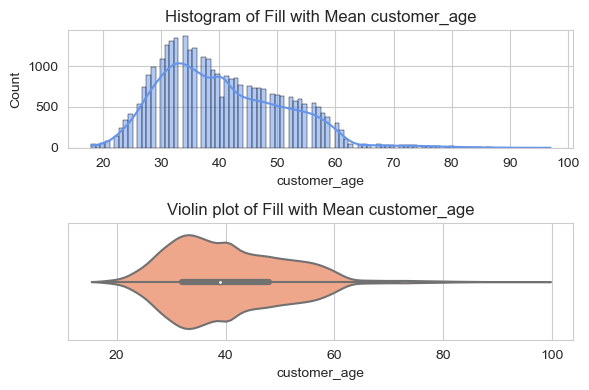

In [20]:
#plot histograms and violins plots for df_mean and df_age of the imputation methods
dfs = [df, df_age, df_mean]
titles = ['Original', 'Based on Marital', 'Fill with Mean']
for i, (df_temp, title) in enumerate(zip(dfs, titles)):
    plt.figure(figsize=(6, 4))
    #hist
    plt.subplot(2,1,1)
    sns.histplot(df_temp['customer_age'], bins=100, color='cornflowerblue', edgecolor='k', kde=True)
    plt.title(f'Histogram of {title} customer_age')

    #violin
    plt.subplot(2,1,2)
    sns.violinplot(x = df_temp['customer_age'], color='lightsalmon')
    plt.title(f'Violin plot of {title} customer_age')
    plt.tight_layout()
    plt.show()

In [21]:
#print all the stats of Age col of the imputed dataframes
for df_temp, title in zip(dfs, titles):

    print(f'Descriptive statistics for {title} Age:')
    print(df_temp['customer_age'].describe())

#There is not much difference since both based on mean, however fill with mean shows less outliers
#fill null age with mean
df['customer_age'] = df['customer_age'].fillna(df['customer_age'].mean())

print(df.isnull().sum())
print(df_con.columns)

Descriptive statistics for Original Age:
count    31028.000000
mean        40.439216
std         10.751392
min         18.000000
25%         32.000000
50%         39.000000
75%         48.000000
max         97.000000
Name: customer_age, dtype: float64
Descriptive statistics for Based on Marital Age:
count    31647.000000
mean        40.432995
std         10.664507
min         18.000000
25%         32.000000
50%         39.000000
75%         48.000000
max         97.000000
Name: customer_age, dtype: float64
Descriptive statistics for Fill with Mean Age:
count    31647.000000
mean        40.439216
std         10.645723
min         18.000000
25%         32.000000
50%         39.000000
75%         48.000000
max         97.000000
Name: customer_age, dtype: float64
id                                      0
customer_age                            0
job_type                                0
marital                                 0
education                               0
default             

In [22]:
#(c) Encoding: convert categorical data into a binary format

def one_hot_encoding(df,col):
    one_hot_encoder=ce.OneHotEncoder(cols=col,return_df=True,use_cat_names=True)
    df_final = one_hot_encoder.fit_transform(df)
    return df_final

print(df["term_deposit_subscribed"].value_counts())
df

term_deposit_subscribed
0    28253
1     3394
Name: count, dtype: int64


,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,id_27290,58.0,admin.,married,secondary,no,567.0,yes,no,cellular,2,feb,99.0,2.0,265.0,3,other,0
31643,id_20428,51.0,management,married,tertiary,no,1072.0,no,no,unknown,20,jun,31.0,7.0,NaN,0,unknown,0
31644,id_44679,41.0,unemployed,married,primary,no,242.0,yes,no,unknown,23,may,89.0,2.0,NaN,0,unknown,0
31645,id_4841,48.0,services,married,secondary,no,2699.0,no,no,cellular,11,aug,216.0,6.0,NaN,0,unknown,0


In [23]:
#(d) fill othe null values for both categorical and numeric data
for i in df.columns:
    if i == "term_deposit_subscribed":
        continue
    if df[i].dtypes == "object" and i !="id":
        # print(i)
        df[i].fillna("unknown",inplace=True)
        df = one_hot_encoding(df,i)
        # print(len(df_train[i].value_counts()))
    elif df[i].isnull().sum()>0:
        if i == "num_contacts_in_campaign":
            df[i].fillna(1.0,inplace=True)
        else:
            df[i].fillna(round(df[i].mean()),inplace=True)

In [24]:
#(e)drop column id
df = df.drop("id", axis=1)

#inspect latest df
print(df.isna().sum())
print(df.duplicated().sum())

customer_age                        0
job_type_management                 0
job_type_blue-collar                0
job_type_technician                 0
job_type_services                   0
job_type_retired                    0
job_type_entrepreneur               0
job_type_admin.                     0
job_type_student                    0
job_type_housemaid                  0
job_type_self-employed              0
job_type_unknown                    0
job_type_unemployed                 0
marital_single                      0
marital_married                     0
marital_divorced                    0
marital_unknown                     0
education_tertiary                  0
education_secondary                 0
education_primary                   0
education_unknown                   0
default_no                          0
default_yes                         0
balance                             0
housing_loan_yes                    0
housing_loan_no                     0
personal_loa

                                    count         mean          std     min  \
customer_age                      31647.0    40.439216    10.645723    18.0   
job_type_management               31647.0     0.210636     0.407767     0.0   
job_type_blue-collar              31647.0     0.215376     0.411089     0.0   
job_type_technician               31647.0     0.164945     0.371136     0.0   
job_type_services                 31647.0     0.092363     0.289542     0.0   
job_type_retired                  31647.0     0.050273     0.218512     0.0   
job_type_entrepreneur             31647.0     0.032768     0.178031     0.0   
job_type_admin.                   31647.0     0.114608     0.318553     0.0   
job_type_student                  31647.0     0.020950     0.143219     0.0   
job_type_housemaid                31647.0     0.028218     0.165596     0.0   
job_type_self-employed            31647.0     0.035106     0.184051     0.0   
job_type_unknown                  31647.0     0.0062

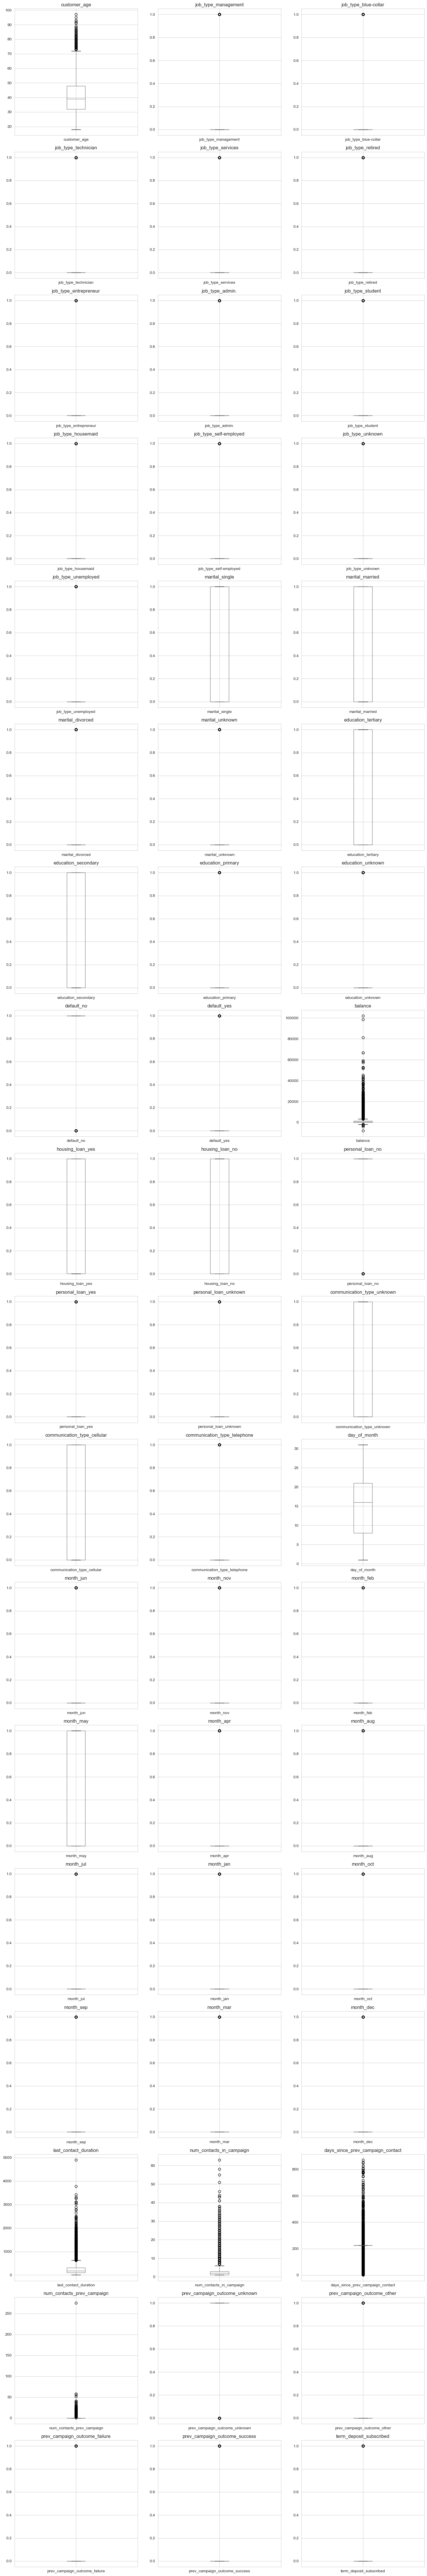

In [25]:
#5.2 Dealing with outliers
print(df.describe().transpose())
#plot a boxplot to see the outliers
# Calculate the number of rows and columns for the subplots
num_columns =  df.shape[1]
num_rows = (num_columns - 1) // 3 + 1

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Flatten the axes array if it's not already flat
if num_rows > 1:
    axes = axes.flatten()

# Loop through the columns and create a boxplot for each
for i, col in enumerate(df.columns):
    ax = axes[i]
    df.boxplot(column=col, ax=ax)
    ax.set_title(col)  # Set the title to the column name

# Remove any empty subplots if num_columns is not a multiple of 3
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
# 6. Data Splitting
# Split the data into training and testing sets
X = df.drop('term_deposit_subscribed', axis=1)  # Features
y = df['term_deposit_subscribed']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Deal with class imbalance using oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [27]:
# 7. Data Normalization
# Standardize features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

In [28]:
# 8.Model Development
# Define the deep learning model
# Define a learning rate scheduler
def lr_schedule(epoch):
    initial_learning_rate = 0.001
    decay = 0.96
    lr = initial_learning_rate * (decay ** epoch)
    return lr

# Create the model with increased L2 regularization
def create_model(input_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.7),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create and compile the model
model = create_model(input_dim=X_train_resampled.shape[1])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement learning rate scheduling
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Create TensorBoard callback
base_log_path = r"logs"
log_path = os.path.join(base_log_path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = callbacks.TensorBoard(log_path)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [29]:
# 9. Model Training
# Train the model with early stopping, learning rate scheduling, and increased L2 regularization
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=64, 
          validation_split=0.2, callbacks=[tb, early_stopping, lr_scheduler])

Epoch 1/50
565/565 [==============================] - 5s 5ms/step - loss: 1.2712 - accuracy: 0.6809 - val_loss: 0.8653 - val_accuracy: 0.7029 - lr: 0.0010
Epoch 2/50
565/565 [==============================] - 2s 4ms/step - loss: 0.6042 - accuracy: 0.8278 - val_loss: 0.4855 - val_accuracy: 0.8831 - lr: 9.6000e-04
Epoch 3/50
565/565 [==============================] - 2s 4ms/step - loss: 0.4382 - accuracy: 0.8455 - val_loss: 0.4561 - val_accuracy: 0.8577 - lr: 9.2160e-04
Epoch 4/50
565/565 [==============================] - 2s 4ms/step - loss: 0.3887 - accuracy: 0.8545 - val_loss: 0.3855 - val_accuracy: 0.8947 - lr: 8.8474e-04
Epoch 5/50
565/565 [==============================] - 2s 4ms/step - loss: 0.3748 - accuracy: 0.8588 - val_loss: 0.3867 - val_accuracy: 0.8916 - lr: 8.4935e-04
Epoch 6/50
565/565 [==============================] - 2s 4ms/step - loss: 0.3670 - accuracy: 0.8592 - val_loss: 0.3546 - val_accuracy: 0.9030 - lr: 8.1537e-04
Epoch 7/50
565/565 [==============================

In [30]:
# 10. Model Evaluation
# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Test Accuracy: {accuracy}")

198/198 [==============================] - 1s 2ms/step
Test Accuracy: 0.868088467614534


In [31]:
# 11. Hypertuning if needed
#since the accuracy is more than 70%, hypertuning won't be needed

In [32]:
#12. Save model in .h5 file
model.save('models/asessment3_model.h5')

c:\Users\ThinkPad\anaconda3\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
#13. Plot and Save model architecture using plot_model function
def visualize_model(model, model_name, save_path):
    """
    Visualize and save the model architecture as a .png file.

    Args:
        model: The trained Keras model.
        model_name: A string representing the model name (used for the filename).
        save_path: The directory where the .png file will be saved.
    """
    # Check if the directory exists, and create it if it doesn't
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Plot the model architecture
    plot_model(model, to_file=f"{save_path}/{model_name}_architecture.png", show_shapes=True, show_layer_names=True)

# Load your trained model here
trained_model = load_model('models/asessment3_model.h5')

# Call the function to visualize and save the model architecture
visualize_model(trained_model, "my_model", "model_visualization")

In [34]:
#14. Save important components so that we can deploy the NLP model elsewhere
#(A) scaler
scaler_save_path = os.path.join(PATH,"scaler.pkl")
with open(scaler_save_path, 'wb') as f:
    pickle.dump(scaler,f)

In [35]:
#Check if the scaler can be loaded 
with open(scaler_save_path, 'rb') as f:
    scaler_loaded = pickle.load(f)
print(type(scaler_loaded))

<class 'sklearn.preprocessing._data.StandardScaler'>


In [36]:
#(B) oversampler
oversampler_save_path = os.path.join(PATH,"oversampler.pkl")
with open(oversampler_save_path, 'wb') as f:
    pickle.dump(oversampler,f)

In [37]:
#Check if the oversampler can be loaded 
with open(oversampler_save_path, 'rb') as f:
    oversampler_loaded = pickle.load(f)
print(type(oversampler_loaded))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'>


In [38]:
#(C) model
model_save_path = os.path.join(PATH, "campaign_outcome_model")
keras.models.save_model(model,model_save_path)

INFO:tensorflow:Assets written to: d:\SHRDC\DL2\hands_on\classification\campaign_outcome_model\assets


INFO:tensorflow:Assets written to: d:\SHRDC\DL2\hands_on\classification\campaign_outcome_model\assets


In [39]:
#Check if the model can be loaded
model_loaded = keras.models.load_model(model_save_path)
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3456      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3456      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                        